# Load library

In [1]:
import os
if not os.getcwd().endswith('m6A'):
    os.chdir('m6A/')
%load_ext rpy2.ipython
from scripts.common import *

data_folder='/home/dengw1/workspace/mouse_lowinput/'

In [2]:
%%R
source('scripts/common.r')
data_folder<-'/home/dengw1/workspace/mouse_lowinput/'

# Figure 2A

In [7]:
peak_intensity=pd.read_csv('m6A_data/peak_intensity_m_1_renamed_gmean.csv',sep='\t',index_col=0)
valid_idx=[]
[valid_idx.append(x) for x in peak_intensity.columns if 'Fetal' not in x]
def tau_index(site_in):
    max_=max(site_in)
    tau=sum([1-(x/max_) for x in site_in])/len(site_in)
    return tau
tau={}
for site in peak_intensity.index:
    tau[site]=tau_index(list(peak_intensity.loc[site,valid_idx]))
pd.Series(tau).to_frame('tau_index').to_csv('ts_data/tau_index_dir.txt')

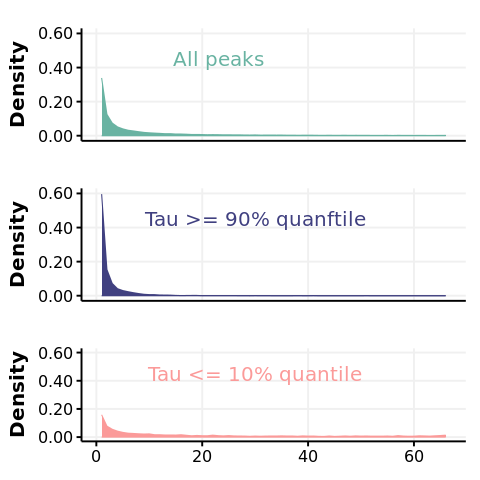

In [5]:
%%R
tau_idx<-read.csv('ts_data/tau_index_dir.txt',header=T,stringsAsFactors=F)
cut<-quantile(tau_idx$tau_index,probs=c(0.1,0.9),na.rm=T)

df_org<-read.csv('ts_data/df_with_sig_renamed.csv',sep='\t',header=T,row.names=1)
pdf('figures/Figure2A_density_tau.pdf')
scale_ <- function(x) sprintf("%.2f", x)

p1<-ggplot() + 
    stat_bin(data=df_org,
             aes(x=Sum, y = ..density..), geom="area",fill="#69b3a2",color='#69b3a2',alpha=1,binwidth=1)+
    annotate('text',x=23, y=0.45, label="All peaks", color="#69b3a2",size=7)  +
    ylab('Density')+scale_colour_Publication()+ theme_Publication()+ 
    scale_y_continuous(labels=scale_,limits=c(0,0.6))+xlab('')+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
p2<-ggplot() + 
    stat_bin(data=df_org[tau_idx[tau_idx$tau_index>=cut['90%'],]$X,],
             aes(x=Sum, y = ..density..), geom="area",fill="#404080",color='#404080',alpha=1,binwidth=1)+
    annotate('text',x=30, y=0.45, label="Tau >= 90% quanftile", color="#404080",size=7)  +
    ## force x axis to end at 66
    annotate('text',x=66, y=0, label="", color="#404080",size=7)  +
    ylab('Density')+scale_colour_Publication()+ theme_Publication()+ 
    scale_y_continuous(labels=scale_,limits=c(0,0.6))+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
     

p3<-ggplot() + 
    stat_bin(data=df_org[tau_idx[tau_idx$tau_index<=cut['10%'],]$X,],
             aes(x=Sum, y = ..density..), geom="area",fill="#fb9a99",color='#fb9a99',alpha=1,binwidth=1)+
    annotate('text',x=30, y=0.45, label="Tau <= 10% quantile", color="#fb9a99",size=7) +
    ylab('Density')+scale_colour_Publication()+ theme_Publication()+ 
    scale_y_continuous(labels=scale_,limits=c(0,0.6))+
    theme(axis.title.x=element_blank())
print(ggarrange(p1,p2,p3,nrow=3))
dev.off()

# Figure 2B

In [24]:
fo=open('ts_data/tau_dist.txt','w')
def one(tissue):
    print(tissue,end=',')
    ret=subprocess.check_output('python3 scripts/Peak_distribution_on_utr_cds.py ts_data/%s.bed'%tissue,
                                shell=True).decode('utf-8')
    return [tissue,ret]


pool=Pool(processes=25)
all_=pool.map(one,['high_tau','low_tau','all_peak'])
pool.close()
pool.join()

for item in all_:
    info=item[1].strip().split('\n')
    for i in range(len(info)):
        fo.write('%s\t%s\t%s\n'%(item[0],i+1,info[i].split('\t')[0]))
fo.close()

df=pd.read_csv('ts_data/tau_dist.txt',sep='\t',header=None,names=['Group','X','Y'])

df.loc[df['Group']=='high_tau','Y']=list(df[df['Group']=='high_tau']['Y']/sum(df[df['Group']=='high_tau']['Y']))
df.loc[df['Group']=='low_tau','Y']=list(df[df['Group']=='low_tau']['Y']/sum(df[df['Group']=='low_tau']['Y']))
df.loc[df['Group']=='all_peak','Y']=list(df[df['Group']=='all_peak']['Y']/sum(df[df['Group']=='all_peak']['Y']))

df['Accumulate']=np.zeros(450)
df.iloc[0:150,3]=[sum(df.iloc[0:x+1,2]) for x in range(150)]
df.iloc[150:300,3]=[sum(df.iloc[150:x+151,2]) for x in range(150)]
df.iloc[300:450,3]=[sum(df.iloc[300:x+301,2]) for x in range(150)]
df.loc[df['Group']=='high_tau','Group']=['High Tau' for x in range(150)]
df.loc[df['Group']=='low_tau','Group']=['Low Tau' for x in range(150)]
df.loc[df['Group']=='all_peak','Group']=['All' for x in range(150)]
df.to_csv('ts_data/tau_dist.txt',sep='\t',index=False)

all_peak,high_tau,low_tau,

In [29]:
%%bash
for peak in high_tau low_tau all_peak
do
mkdir -p ts_data/tau/homer_$peak
/root/homer/bin/findMotifsGenome.pl ts_data/$peak.bed hg19 ts_data/tau/homer_$peak -rna -len 5,6,7 -p 10 -size 100 -S 10 
done


	Position file = ts_data/high_tau.bed
	Genome = hg19
	Output Directory = ts_data/tau/homer_high_tau
	Operating in RNA mode
	Motif length set at 5,6,7,
	Using 10 CPUs
	Fragment size set to 100
	Will optimize 10 putative motifs
	Found mset for "human", will check against vertebrates motifs
sh: 1: bed2pos.pl: not found
sh: 1: checkPeakFile.pl: not found
sh: 1: cleanUpPeakFile.pl: not found
ls: cannot access '/root/homer/.//data/genomes/hg19//preparsed//hg19.*.cgbins': No such file or directory
	Could not find background files for 100 bp fragments
	Below are the sizes that are already available prepared.
	HOMER will now create background files for 100 bp fragments
	To CANCEL and rerun with a differet "-size <#>", hit <CTRL+C> now!
		5
		4
		3
		2
		1
	Preparsing genome for 100 bp fragments...(will probably take 1-5 min)
sh: 1: preparseGenome.pl: not found
wc: /root/homer/.//data/genomes/hg19//preparsed//hg19.100.gcbins: No such file or directory
Use of uninitialized value $lineCount in nu

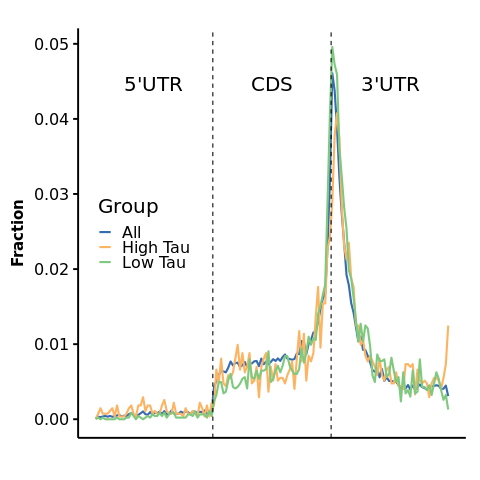

In [7]:
%%R
df_dist<-read.table('ts_data/tau_dist.txt',sep='\t',header=T,stringsAsFactors=T)

sep1=50.5
sep2=100.5
p<-ggplot(df_dist,aes(x=X,y=Y,color=Group,group=Group))+geom_line(size=1)+
    geom_vline(xintercept=c(sep1, sep2), linetype='dashed', size = 0.5) +
  annotate('text', label=c("5'UTR", "CDS", "3'UTR"), size = 7,x=c( sep1/2, (sep1+sep2)/2, sep2+sep1/2 ),
           y=max(df_dist[,3])*0.9)  +
    ylab('Fraction')+xlab('Bin')+
    scale_colour_Publication()+ theme_Publication()+
    theme(panel.spacing = unit(0.5, 'lines'),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
#         text = element_text(size=15),
#         axis.text.y = element_text(size=15),
        axis.title.y = element_text(size=15),
        legend.position = c(0.17,0.5),
        axis.ticks.x=element_blank(),
        axis.text.x=element_blank())+
    guides(color=guide_legend(ncol=1,title.position='top'))+xlab('')
pdf('figures/Figure2B_distribution.pdf',height=4.5)
print(p)
dev.off()
print(p)

# Figure S3A

png 
  2 


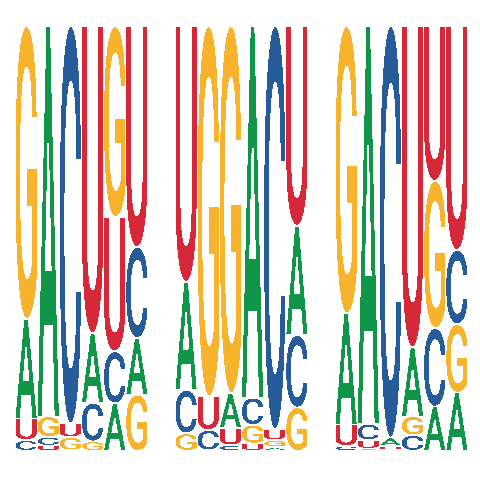

In [43]:
%%R
demo_tissue<-c('high_tau','low_tau','all_peak') # Adult brain, adult heart and adult small intestine
plot_data1 = function (tissue) {
    seq_matrix<-read.csv(paste0('ts_data/tau/homer_',tissue,'/homerResults/motif1.motif'),skip=1,sep='\t')
    colnames(seq_matrix)=c('A','C','G','U')
    seq_matrix<-t(seq_matrix)
    ggplot() + geom_logo(seq_matrix, method = 'prob') + theme_logo() +
    theme(axis.text.x = element_blank(),panel.spacing = unit(0.5, 'lines'),
        axis.text.y = element_blank(),axis.title.y = element_blank(),axis.title.x = element_blank(),
        plot.title = element_text(hjust = 0.5, size=30, face='bold'),legend.position = 'none') 
}

figs <- lapply(demo_tissue, plot_data1)

print(ggarrange(plotlist=figs,ncol=3))

pdf('figures/Figure2_S3A_seqlog.pdf',width=14,height=4)
print(ggarrange(plotlist=figs,nrow=1))
dev.off()

# Figure 2C,D,E 

In [36]:
## Load xml in xxx to igv and export as SVG, then open SVG file in Adobe Illustrator

# Figure 2F

In [8]:
%%R
### Generate significant groups
intensity_all<-read.table('m6A_data/peak_intensity_m_1_renamed_gmean.csv',sep='\t',header=T,row.names=1)
intensity_h<-intensity_all[tau_idx[tau_idx$tau_index>=cut['90%'],]$X,]
intensity_h<-intensity_h[complete.cases(intensity_h),]

spl<-t(as.data.frame(strsplit(colnames(intensity_h),'_')))
colnames(spl)<-c('Group','Age','Tissue')
tissue_group<-as.vector(spl[,'Group'])
tissue_age<-as.vector(spl[,'Age'])

group_color=group_color=c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")
names(group_color)<-unique(tissue_group)

column_ha=HeatmapAnnotation(
  Age=tissue_age,
  Group=tissue_group,
  col=list(Age=c("Adult"="pink","Fetal"="yellowgreen"),Group=group_color)
  )

intensity_m<-intensity_h[,FALSE]
groups<-unique(tissue_group)

'%!in%' <- function(x,y)!('%in%'(x,y))
group_t_test<-function(y1,y2){
    ret<-c()
    for(i in c(1:nrow(y1))){
        test_<-t.test(y1[i,],y2[i,],alternative='g')
        p_<-test_$p.value
        ret<-c(ret,p_)
    }
    return(ret)
}
which_grp<-function(x)groups[which.min(x)[1]]
for(group in groups){
    group_idx<-which(tissue_group %in% c(group) & tissue_age %!in% c('Fetal'))
    non_group_idx<-which(c(1:66) %!in% group_idx & tissue_age %!in% c('Fetal'))
    
    y1<-intensity_h[,group_idx]
    y2<-intensity_h[,non_group_idx]
    print(group)
    intensity_m[,group]<-group_t_test(intensity_h[,group_idx],intensity_h[,non_group_idx])
}
intensity_m$sig_grp<-apply(intensity_m,1,which_grp)
write.csv(intensity_m,file='ts_data/significant_grp.txt')

[1] "CirculatorySystem"
[1] "DigestiveSystem"
[1] "GlandularTissues"
[1] "ImmuneSystem"
[1] "NervousSystem"
[1] "Other"
[1] "ReproductiveSystem"
[1] "RespiratorySystem"
[1] "UrinarySystem"


In [70]:
%%R
####### Perform enrichment analysis #######
sig_grp<-read.csv('ts_data/significant_grp.txt',row.names=1)

CirculatorySystem<-rownames(sig_grp[sig_grp$sig_grp=='CirculatorySystem',])
DigestiveSystem<-rownames(sig_grp[sig_grp$sig_grp=='DigestiveSystem',])
NervousSystem<-rownames(sig_grp[sig_grp$sig_grp=='NervousSystem',])

peak2gene<-read.csv('m6A_data/peak2gene.txt',sep='\t',header=F,stringsAsFactors=F,row.names=1)
write.csv(unique(peak2gene[NervousSystem,'V2']),file='ts_data/NervousSystem.txt',row.names=F,quote=F,col.names=NA)
write.csv(unique(peak2gene[DigestiveSystem,'V2']),file='ts_data/DigestiveSystem.txt',row.names=F,quote=F,col.names=NA)
write.csv(unique(peak2gene[CirculatorySystem,'V2']),file='ts_data/CirculatorySystem.txt',row.names=F,quote=F,col.names=NA)

system('python3 scripts/hyper_geometry.py ts_data/NervousSystem.txt ts_data/DigestiveSystem.txt ts_data/CirculatorySystem.txt')

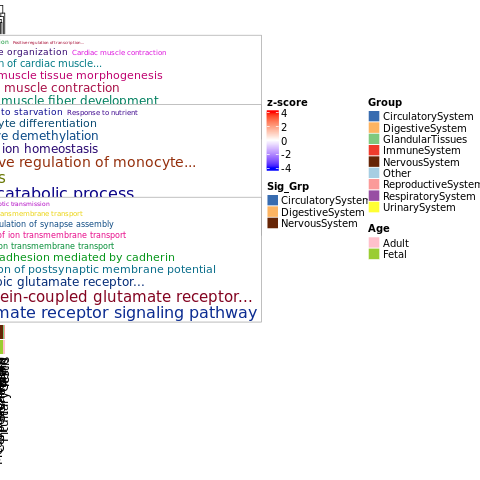

In [9]:
%%R
library(rlist)
tau_idx<-read.csv('ts_data/tau_index_dir.txt',header=T,stringsAsFactors=F)
sig_grp<-read.csv('ts_data/significant_grp.txt',row.names=1)
cut<-quantile(tau_idx$tau_index,probs=c(0.1,0.9),na.rm=T)

intensity_all<-read.table('m6A_data/peak_intensity_m_1_renamed_gmean.csv',sep='\t',header=T,row.names=1)
intensity_h<-intensity_all[tau_idx[tau_idx$tau_index>=cut['90%'],]$X,]
intensity_h<-intensity_h[complete.cases(intensity_h),]

spl<-t(as.data.frame(strsplit(colnames(intensity_h),'_')))
colnames(spl)<-c('Group','Age','Tissue')
tissue_group<-as.vector(spl[,'Group'])
tissue_age<-as.vector(spl[,'Age'])

group_color=group_color=c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")
names(group_color)<-unique(tissue_group)

column_ha=HeatmapAnnotation(
  Group=tissue_group,
  Age=tissue_age,
  col=list(Group=group_color,Age=c("Adult"="pink","Fetal"="yellowgreen"))
)


col_fun = colorRamp2(c(-4, 0, 4), c("blue", "white", "red"))

mat<-t(scale(t(as.matrix(intensity_h))))
CirculatorySystem<-intersect(rownames(sig_grp[sig_grp$sig_grp=='CirculatorySystem',]),rownames(mat))
DigestiveSystem<-intersect(rownames(sig_grp[sig_grp$sig_grp=='DigestiveSystem',]),rownames(mat))
NervousSystem<-intersect(rownames(sig_grp[sig_grp$sig_grp=='NervousSystem',]),rownames(mat))
sig_dif<-c(CirculatorySystem,c(DigestiveSystem,NervousSystem))
mat<-mat[sig_dif,]
clst_c<-hclust(as.dist(1-cor(mat, method="spearman")),method='complete')

Sig_Grp<-c(rep('CirculatorySystem',times=length(CirculatorySystem)),
           rep('DigestiveSystem',times=length(DigestiveSystem)),
           rep('NervousSystem',times=length(NervousSystem)))
row_ha=rowAnnotation(
  Sig_Grp=Sig_Grp,
  col=list(Sig_Grp=c("NervousSystem"="#662506","CirculatorySystem"="#386cb0","DigestiveSystem"="#fdb462"))
)

align_to = split(seq_len(nrow(mat)), c(rep(1,times=length(CirculatorySystem)),
                                       rep(2,times=length(DigestiveSystem)),
                                       rep(3,times=length(NervousSystem))))

keywords<-read.csv('ts_data/GO_enrichment.txt',sep='\t',header=T,stringsAsFactors = F)
keywords<-keywords[,c('Group','GO_Term','E_ratio')]
keywords_n<-list()
keywords_n<-list.append(keywords_n,'1'=keywords[keywords$Group=='CirculatorySystem',c('GO_Term','E_ratio')])
keywords_n<-list.append(keywords_n,'2'=keywords[keywords$Group=='DigestiveSystem',c('GO_Term','E_ratio')])
keywords_n<-list.append(keywords_n,'3'=keywords[keywords$Group=='NervousSystem',c('GO_Term','E_ratio')])
fontsize_range = c(4, 16)
gbl = lapply(names(align_to), function(nm) {
  kw = keywords_n[[nm]][, 1]
  freq = keywords_n[[nm]][, 2]
  fontsize = scale_fontsize(freq, rg = c(1, max(10, freq)), fs = fontsize_range)
  
  word_cloud_grob(text = kw, fontsize = fontsize)
})
names(gbl) = names(align_to)
margin = unit(8, "pt")
gbl_h = lapply(gbl, function(x) convertHeight(grobHeight(x), "cm") + margin)
gbl_h = do.call(unit.c, gbl_h)
gbl_w = lapply(gbl, function(x) convertWidth(grobWidth(x), "cm"))
gbl_w = do.call(unit.c, gbl_w)
gbl_w = max(gbl_w) + margin
panel_fun = function(index, nm) {
  # background
  grid.rect(gp = gpar(fill = "#FFFFFF", col = NA))
  # border
  grid.lines(c(0, 1, 1, 0), c(0, 0, 1, 1), gp = gpar(col = "#AAAAAA"), 
             default.units = "npc")
  gb = gbl[[nm]]
  # a viewport within the margins
  pushViewport(viewport(x = margin/2, y = margin/2, 
                        width = grobWidth(gb), height = grobHeight(gb),
                        just = c("left", "bottom")))
  grid.draw(gb)
  popViewport()
}
col_fun = colorRamp2(c(-4, 0, 4), c("blue", "white", "red"))

colnames(mat)<-spl[,'Tissue']
ht<-Heatmap(mat,name='z-score',cluster_columns=clst_c,cluster_rows = F,bottom_annotation = column_ha,show_row_name=F,
            col=col_fun,show_row_dend =F,right_annotation = row_ha,use_raster=FALSE)
ht = ht + rowAnnotation(keywords = anno_link(align_to = align_to, 
                                             which = "row", panel_fun = panel_fun, 
                                             size = gbl_h, gap = unit(2, "mm"), 
                                             width = gbl_w + unit(5, "mm"), # 5mm for the link
                                             link_gp = gpar(fill = "#FFFFFF", col = "#AAAAAA"), 
                                             internal_line = FALSE))
# pdf('figures/Figure2F_tissue_specificity.pdf',width=14,height=8)
draw(ht)
# dev.off()

In [ ]:
# Figure S3 